In [7]:
import os

# May be necessary on Unix systems. Uncomment above sklearn import below
os.environ['OPENBLAS_NUM_THREADS'] = '15'
os.environ['JOBLIB_START_METHOD'] = 'forkserver'

import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from time import strftime, gmtime
import random
import json

In [ ]:
env = gym.make('HandManipulateBlockRotateZ-v0')
ALPHA = 0.05 # learning rate for q-learning
GAMMA = 0.9 # discount rate for q-learning

In [3]:
# Pulls the following from the observation object:
# - object's Z rotation (represented by 2 values from its quarternion)
# - target Z rotation (represented by 2 values from its quarternion)
def get_state_from_observation(observation):
     # List of length 7, first 3 elements are pos and last 4 are rotation in quaternion format
    current_state = observation["achieved_goal"]

    current_z_rotation_1 = current_state[3]
    current_z_rotation_2 = current_state[6]

    goal_state = observation["desired_goal"]
    goal_z_rotation_1 = goal_state[3]
    goal_z_rotation_2 = goal_state[6]

    state = np.array([current_z_rotation_1, current_z_rotation_2, goal_z_rotation_1, goal_z_rotation_2])

    # Round state values to nearest 0.1
    np.around(state, decimals=1, out=state)
    # Clip state values to [-1, 1]
    np.clip(state, -1, 1, out=state)
    
    # Replace strange -0 with normal 0
    state[state==(-0.)] = 0
    
    return state


# Returns best action we can take in the current state as a 
# tuple of (action, q_value)
def get_best_action_for_state(q_table, state):
    if state.tobytes() not in q_table:
        print("ERROR: State " + str(state) + " not in q table")
        raise ValueError
        
    possible_actions = q_table[state.tobytes()]
    
    best_action = None
    best_q_value = None
    for action_value_tuple in possible_actions:
        action = action_value_tuple[0]
        value = action_value_tuple[1]
        
        # Note: given that most actions will have q value of 0, this will often pick the first
        # action with q-value 0 in the list, as the ones before it will likely have negative values
        if best_q_value is None or best_q_value < value:
            best_q_value = value
            best_action = action

    assert(best_action is not None)
    assert(best_q_value is not None)
    
    return best_action, best_q_value

# Updates Q_value for given state and action based on new_state and reward
# Returns updated q value
def update_q_value(q_table, state, action, new_state, reward):
    action_tuples_for_state = q_table[state.tobytes()]
    
    # find current action tuple
    action_tuple_idx = None
    cur_q_value = None
    for idx, action_tuple in enumerate(action_tuples_for_state):
        an_action = action_tuple[0]
        value = action_tuple[1]
        
        # If action is the one we just took
        if np.array_equal(an_action, action):
            # Record its current q value
            action_tuple_idx = idx
            cur_q_value = value
            
    assert(action_tuple_idx is not None)
    assert(cur_q_value is not None)
    
    # find next state's best possible action
    best_action_for_new_state = get_best_action_for_state(q_table, new_state)
    best_value_for_new_state = best_action_for_new_state[1]
    
    # calculate new q value
    new_q_value = cur_q_value + ALPHA * (reward + GAMMA * best_value_for_new_state - cur_q_value)
    
    # record new q_value
    q_table[state.tobytes()][action_tuple_idx] = (action, new_q_value)
    
    return q_table
    
    
# Adds given length 20 array relative_action to the robots current poisition in order to
# get absolute version of action
def convert_to_absolute_action(robot_cur_pos, relative_action):
    assert(len(robot_cur_pos) == 20)
    assert(len(relative_action) == 20)

    absolute_action = np.add(robot_cur_pos, relative_action)

    return absolute_action


# Constructs Q Table as a dict with states as keys and lists as values.
# The lists have tuples of (action, q-value)
def make_q_table():
    tenths = [i/10 for i in range(-10, 11)] # -1 to 1 in 0,1 step vcalues
    
    # Create every possible state
    state_param_grid = {
        "cur_z_1" : tenths,
        "cur_z_2": tenths,
        "goal_z_1": tenths,
        "goal_z_2": tenths
    }
    state_grid = ParameterGrid(state_param_grid) 
    
    # Create every possible action
    action_param_grid = {}
    for i in range(20):
        if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: # Only exploring actions for these indecies of the (20,) action space
            action_param_grid[i] = [-0.25, 0.25]
        else:
            action_param_grid[i] = [0]
    
    # every possible action
    action_grid = ParameterGrid(action_param_grid)

    # Create list of action/Q-value tuples
    default_action_value_tuples = []
    for possible_action in list(action_grid):
        action = np.array(list(possible_action.values()))
        default_action_value_tuples.append((action, 0))
    
    # MAKE TABLE
    q_table = {}
    
    # for every possible state
    for possible_state in list(state_grid):      
        state = np.array(list(possible_state.values()))
            
        # Map state -> list of action/qvalue tuples
        q_table[state.tobytes()] = default_action_value_tuples

    return q_table

# Runs an episode of the simulation using the global Q table
# If should_learn is False, does not update Q table
# Returns sum of episode rewards
def run_episode(should_learn=True):
    global Q_TABLE
    
    done = False
    timestep = 0
    total_episode_reward = 0

    # get initial state
    observation = env.reset()
    state = get_state_from_observation(observation)
    
    while not done:
        # env.render()

        # Take best action we know
        relative_action = get_best_action_for_state(Q_TABLE, state)[0]

        robot_cur_pos = observation["observation"][:20]
        absolute_action = convert_to_absolute_action(robot_cur_pos, relative_action)

        # Observe new state
        observation, reward, done, info = env.step(absolute_action)
        new_state = get_state_from_observation(observation)
        
        if should_learn:
            Q_TABLE = update_q_value(Q_TABLE, state, relative_action, new_state, reward)
        
        state = new_state
        total_episode_reward += reward
        timestep += 1

    return total_episode_reward

# Runs an episode of the simulation using random actions.
# Returns sum of episode rewards
def run_random_episode():    
    done = False
    timestep = 0
    total_episode_reward = 0

    # get initial state
    observation = env.reset()
    
    while not done:
        # Take random action
        action = env.action_space.sample()
        
        # Observe new state
        observation, reward, done, info = env.step(action)

        total_episode_reward += reward
        timestep += 1

    return total_episode_reward

# Given an array of epochs where each epoch is a list of episode rewards,
# returns an array of the same length with the success rate of each epoch's episodes.
# Success is defined as reward > -100
def calculate_success_frequency(epochs):
    epoch_success_failure = np.array(epochs) > -100
    
    epoch_num = len(epochs[0])
    epoch_num_success = np.count_nonzero(epoch_success_failure, axis=1)
    
    epoch_success_rate = epoch_num_success / epoch_num
    
    return epoch_success_rate

In [4]:
print("Start making Q Table at " + strftime("%a, %d %b %Y %H:%M:%S +0000", gmtime()))
Q_TABLE = make_q_table()
print("Finished making Q Table at " + strftime("%a, %d %b %Y %H:%M:%S +0000", gmtime()))
# list(Q_TABLE.items())[0]

Start making Q Table at Wed, 22 Apr 2020 16:41:33 +0000
Finished making Q Table at Wed, 22 Apr 2020 16:41:34 +0000


In [ ]:
# MAIN DRIVER
# Runs epochs with 1900 episodes each
# At the end of every epoch, runs test episodes to obtain success rate

num_epochs = 25
num_episodes_per_epoch = 1900 # To match OpenAI's research paper
num_test_episodes_per_epoch = 100

epoch_rewards = [] # stores an array per epoch with the sum of rewards per episode
epoch_test_rewards = [] # stores an array per epoch with sum of rewards per test_episode

for epoch in range(num_epochs):
    print("Starting epoch " + str(epoch) + " at " + strftime("%a, %d %b %Y %H:%M:%S +0000", gmtime()))
    
    # Run the training episodes for this epoch
    episode_rewards = [] # stores sum of rewards per episode
    for episode in range(num_episodes_per_epoch):
        episode_reward = run_episode()
        episode_rewards.append(episode_reward)
    epoch_rewards.append(episode_rewards)
    
    # Run the test episodes for this epoch
    test_rewards = [] # stores sum of rewards per test episode
    for test_episode in range(num_test_episodes_per_epoch):
        test_reward = run_episode(should_learn=False) # Note: Does not update Q Table during tests
        test_rewards.append(test_reward)
    epoch_test_rewards.append(test_rewards)
    
    print("Finished epoch " + str(epoch) + " at " + strftime("%a, %d %b %Y %H:%M:%S +0000", gmtime()))

    np.savetxt("../data/q_learning_long_epoch_rewards.txt", epoch_rewards)
    np.savetxt("../data/q_learning_long_epoch_test_rewards.txt", epoch_test_rewards)

Starting epoch 0 at Thu, 23 Apr 2020 03:19:10 +0000
Finished epoch 0 at Thu, 23 Apr 2020 03:42:00 +0000
Starting epoch 1 at Thu, 23 Apr 2020 03:42:00 +0000


### PARAMETER SEARCH

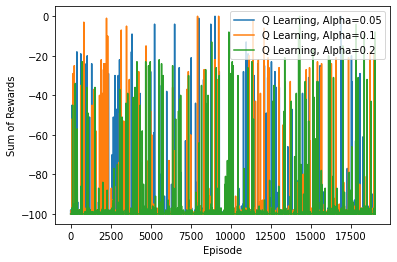

In [103]:
# PLOT SUM OF REWARDS VS EPISODE
q_learning_05 = np.loadtxt("../data/q_learning_05_alpha_epoch_rewards.txt").flatten()
q_learning_10 = np.loadtxt("../data/q_learning_10_alpha_epoch_rewards.txt").flatten()
q_learning_20 = np.loadtxt("../data/q_learning_20_alpha_epoch_rewards.txt").flatten()

plt.plot(q_learning_05, label="Q Learning, Alpha=0.05")
plt.plot(q_learning_10, label="Q Learning, Alpha=0.1")
plt.plot(q_learning_20, label="Q Learning, Alpha=0.2")
plt.xlabel('Episode')
plt.ylabel('Sum of Rewards')
plt.legend(loc="upper right")
plt.show()

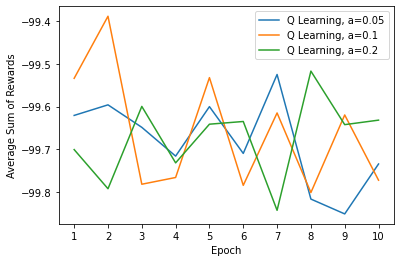

In [102]:
# PLOT AVERAGE SUM OF REWARDS VS EPOCH
q_learning_05_per_epoch = np.mean(np.loadtxt("../data/q_learning_05_alpha_epoch_rewards.txt"), axis=1)
q_learning_10_per_epoch = np.mean(np.loadtxt("../data/q_learning_10_alpha_epoch_rewards.txt"), axis=1)
q_learning_20_per_epoch = np.mean(np.loadtxt("../data/q_learning_20_alpha_epoch_rewards.txt"), axis=1)

plt.plot(q_learning_05_per_epoch, label="Q Learning, a=0.05")
plt.plot(q_learning_10_per_epoch, label="Q Learning, a=0.1")
plt.plot(q_learning_20_per_epoch, label="Q Learning, a=0.2")
plt.xlabel('Epoch')
plt.ylabel('Average Sum of Rewards')
plt.xticks(list(range(10)), list(range(1, 11)))
plt.legend(loc="upper right")
plt.show()

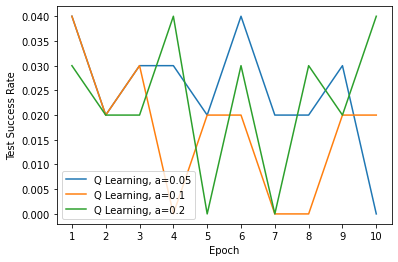

In [86]:
# PLOT TEST SUCCESS RATE VS EPOCH
q_learning_05_test = np.loadtxt("../data/q_learning_05_alpha_epoch_test_rewards.txt")
q_learning_05_test = calculate_success_frequency(q_learning_05_test)
q_learning_10_test = np.loadtxt("../data/q_learning_10_alpha_epoch_test_rewards.txt")
q_learning_10_test = calculate_success_frequency(q_learning_10_test)
q_learning_20_test = np.loadtxt("../data/q_learning_20_alpha_epoch_test_rewards.txt")
q_learning_20_test = calculate_success_frequency(q_learning_20_test)

plt.plot(q_learning_05_test, label="Q Learning, a=0.05")
plt.plot(q_learning_10_test, label="Q Learning, a=0.1")
plt.plot(q_learning_20_test, label="Q Learning, a=0.2")
plt.xlabel('Epoch')
plt.ylabel('Test Success Rate')
plt.xticks(list(range(10)), list(range(1, 11)))
plt.legend(loc="lower left")
plt.show()

### FINAL ANALYSIS

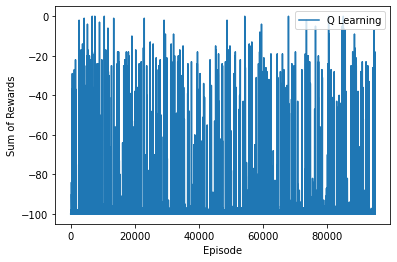

In [16]:
# PLOT SUM OF REWARDS VS EPISODE
q_learning_long = np.loadtxt("../data/q_learning_long_epoch_rewards.txt").flatten()
q_learning_long_2 = np.loadtxt("../data/q_learning_long2_epoch_rewards.txt").flatten()

q_learning_long = np.concatenate((q_learning_long, q_learning_long_2))

plt.plot(q_learning_long, label="Q Learning")
plt.xlabel('Episode')
plt.ylabel('Sum of Rewards')
plt.legend(loc="upper right")
plt.show()

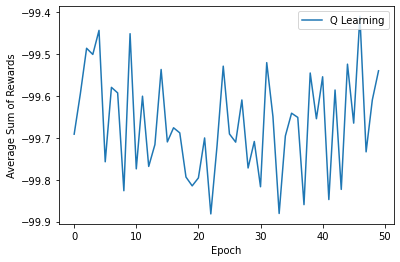

In [30]:
# PLOT AVERAGE SUM OF REWARDS VS EPOCH
q_learning_long = np.mean(np.loadtxt("../data/q_learning_long_epoch_rewards.txt"), axis=1)
q_learning_long_2 = np.mean(np.loadtxt("../data/q_learning_long2_epoch_rewards.txt"), axis=1)

q_learning_long = np.concatenate((q_learning_long, q_learning_long_2))

plt.plot(q_learning_long, label="Q Learning")

plt.xlabel('Epoch')
plt.ylabel('Average Sum of Rewards')
plt.legend(loc="upper right")
plt.show()

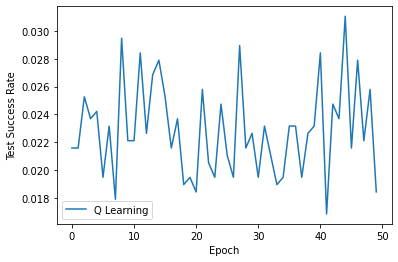

In [31]:
# PLOT TEST SUCCESS RATE VS EPOCH
q_learning_long = np.loadtxt("../data/q_learning_long_epoch_rewards.txt")
q_learning_long = calculate_success_frequency(q_learning_long)
q_learning_long_2 = np.loadtxt("../data/q_learning_long2_epoch_rewards.txt")
q_learning_long_2 = calculate_success_frequency(q_learning_long_2)

q_learning_long = np.concatenate((q_learning_long, q_learning_long_2))

plt.plot(q_learning_long, label="Q Learning")
plt.xlabel('Epoch')
plt.ylabel('Test Success Rate')
# plt.xticks(list(range(10)), list(range(1, 11)))
plt.legend(loc="lower left")
plt.show()